In [39]:
from preamble import *
from sklearn.model_selection import GridSearchCV
%matplotlib inline

## Algorithm Chains and Pipelines

In [40]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [41]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))


Test score: 0.97


### Building Pipelines

In [42]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [43]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [44]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


### Using Pipelines in Grid-searches

In [45]:
param_grid = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [46]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


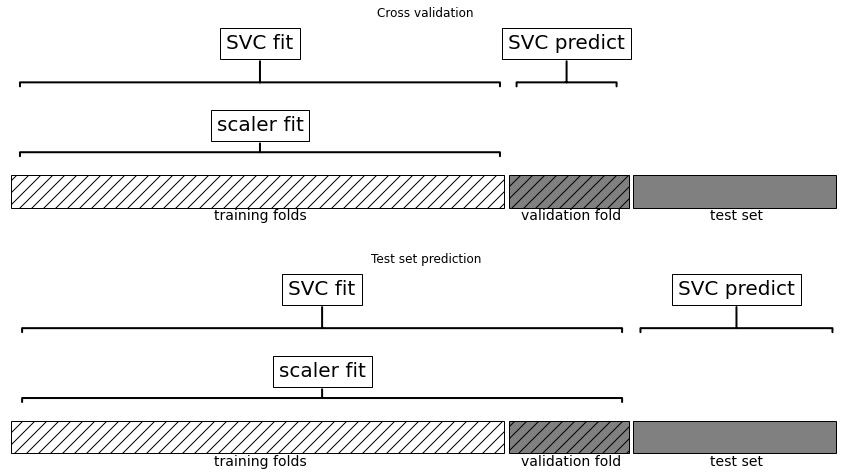

In [47]:
mglearn.plots.plot_proper_processing()

In [48]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [49]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))
))

Cross-validation accuracy (cv only on ridge): 0.91


In [51]:
pipe = Pipeline([("select", SelectPercentile(
    score_func=f_regression,
    percentile=5
    )), ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))
))

Cross-validation accuracy (pipeline): -0.25


### The General Pipeline Interface

In [52]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [53]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

![pipeline_illustration](images/pipeline.png)

### Convenient Pipeline creation with ``make_pipeline``

In [54]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [55]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


#### Accessing step attributes

In [57]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


#### Accessing Attributes in a Pipeline inside GridSearchCV

In [58]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [59]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [61]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [62]:
print("Logistic regression step:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1, max_iter=1000)


In [63]:
print("Logistic regression coefficients:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.436 -0.343 -0.408 -0.534 -0.15   0.61  -0.726 -0.785  0.039  0.275
  -1.298  0.049 -0.673 -0.934 -0.139  0.45  -0.13  -0.101  0.434  0.716
  -1.091 -1.095 -0.852 -1.064 -0.743  0.073 -0.823 -0.653 -0.644 -0.42 ]]


### Grid-searching preprocessing steps and model parameters

In [64]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [65]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [66]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

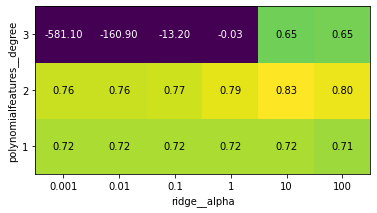

In [67]:
mglearn.tools.heatmap(
    grid.cv_results_['mean_test_score'].reshape(3, -1),
    xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
    xticklabels=param_grid['ridge__alpha'],
    yticklabels=param_grid['polynomialfeatures__degree'], vmin=0
)

In [68]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [69]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [70]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


In [71]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [72]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.98


#### Avoiding Redundant Computation

In [74]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")
